This code was made to give any pulse profile and from it obtain the full-width-at-half-maximum (FWHM) of the profile. This was done by creating a multi-Gaussian fit. The algorithm starts by fitting a single Gaussian and will continue to fit additional Gaussians until the residuals between the original data and the fit are less than 5% or are less than the off-pulse RMS.

In [1]:
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
import math
from scipy.stats import chisquare

### Define the Functions

In [2]:
#This function is used to insert an array before the last element of another array (created partly by ChatGPT)
def insert_array_before_last(arr, array_to_insert):
    if len(arr) >= 1:
        index_to_insert = len(arr) - 1
        array_to_insert_without_last = array_to_insert[:-1]  # Remove the last element
        arr = np.insert(arr, index_to_insert, array_to_insert_without_last)
        return arr
    else:
        print("The array must have at least one element to insert before the last index.")

In [3]:
def degrees_to_radians(degrees):
    radians = degrees * (math.pi / 180)
    return radians

In [4]:
def map_to_degrees(array):
    max_value = max(array)
    degrees_array = [(value / max_value) * 360 for value in array]
    return degrees_array

In [5]:
def val_to_deg(value, data, k):
    if isinstance(data[k], np.ndarray):
        degrees_value = (value / len(data[k])) * 360
        return degrees_value
    else:
        raise ValueError("data[k] should be a NumPy array")

In [6]:
def map_to_1024(array):
    max_value = max(array)
    degrees_array = [(value / 1023) * 360 for value in array]
    return degrees_array

In [7]:
def convert_subset_to_degrees(subset_array, full_rotation_length=1024):
    """
    Convert a subset array to degrees based on the assumption that a full rotation
    corresponds to the specified length.

    Parameters:
    - subset_array: numpy array, the subset of data to be converted to degrees.
    - full_rotation_length: int, the length of the full rotation (default is 1024).

    Returns:
    - degrees_array: numpy array, the converted values in degrees.
    """

    # Calculate the degrees per index
    degrees_per_index = 360 / full_rotation_length

    # Convert the subset array to degrees
    degrees_array = subset_array * degrees_per_index

    return degrees_array

In [8]:
def calculate_rms(array):
    """
    Calculate the Root Mean Square (RMS) of an array of values.

    Parameters:
    - array (numpy.ndarray): Input array of values.

    Returns:
    - float: RMS value.
    
    Function created partly by ChatGPT
    """
    if len(array) == 0:
        raise ValueError("Input array is empty")

    # Square each element in the array
    squared_values = np.square(array)

    # Calculate the mean of the squared values
    mean_squared = np.mean(squared_values)

    # Calculate the square root of the mean squared value
    rms = np.sqrt(mean_squared)

    return rms

In [9]:
#This function is used to smooth the data
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [10]:
#Function to add an a value to every third index of an array starting at index 1. Created to shift the param_arr positions.
def add_value_to_every_third(arr, value):
    for i in range(1, len(arr), 3):
        arr[i] += value
    return arr

# Example usage:
original_array = [1, 2, 3, 4, 5, 6, 7, 8, 9]
value_to_add = 10

result_array = add_value_to_every_third(original_array, value_to_add)

In [11]:
def apply_function_to_indices(input_array, function_to_apply):
    """
    Apply a specified function to every 2nd and 3rd index in an array.

    Parameters:
    - input_array: numpy array, the input array.
    - function_to_apply: function, the function to apply to the selected indices.

    Returns:
    - result_array: numpy array, the array with the function applied to selected indices.
    """

    result_array = input_array.copy()  # Create a copy to avoid modifying the original array

    # Apply the function to every 2nd and 3rd index
    result_array[1::2] = function_to_apply(result_array[1::2])
    result_array[2::3] = function_to_apply(result_array[2::3])

    return result_array


In [12]:
#Define a Gaussian and its different parameters
def gaussian(x, amp1,cen1,sigma1,b):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + b

In [13]:
#Define a profile with 4 aded gaussians
def _2gaussian(x, A1, p1, w1, A2, p2, w2, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + b

In [14]:
#Define a profile with 4 aded gaussians
def _3gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + b

In [15]:
#Define a profile with 4 aded gaussians
def _4gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, b):
     return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + b

In [16]:
#Define a profile with 5 added gaussians
def _5gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + \
     gaussian(x, A4, p4, w4, 0) +  gaussian(x, A5, p5, w5, 0) + b

In [17]:
#Define a profile with 6 added gaussians
def _6gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + b

In [18]:
#Define a profile with 7 added gaussians
def _7gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + b

In [19]:
#Define a profile with 8 added gaussians
def _8gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) + b

In [20]:
#Define a profile with 9 added gaussians
def _9gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, A9, p9, w9, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + b

In [21]:
#Define a profile with 10 added gaussians
def _10gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6,\
                A7, p7, w7, A8, p8, w8, A9, p9, w9, A10, p10, w10, b):
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + gaussian(x, A10, p10, w10, 0) + b

In [22]:
#This function deterrmines which number of added gaussians to return depending on the iteration
def which_gauss(i, xdata, p0_arr):
        gauss_arr = []
        if i == 1:
            gauss_arr = gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3])
        elif i == 2:
            gauss_arr = _2gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6])
        elif i == 3:
            gauss_arr = _3gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9])
        elif i == 4:
            gauss_arr = _4gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12])
        elif i == 5:
            gauss_arr = _5gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15])
        elif i == 6:
            gauss_arr = _6gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18])    
        elif i == 7:
            gauss_arr = _7gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21])
        elif i == 8:
            gauss_arr = _8gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24])  
        elif i == 9:
            gauss_arr = _9gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27])          
        elif i == 10:
            gauss_arr = _10gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27], p0_arr[28], p0_arr[29], p0_arr[30])
        return(gauss_arr)


In [23]:
#Define the function to minimize with the least_squares algorithm
def fit_func(p, x, y):
    if np.any(p<0):
        return np.inf
    return y - gaussian(x, *p)

In [24]:
def convert_allvals_to_deg(x_on_pulse_aligned, pulse_center, first_cutoff, last_cutoff, param_arr):
    x_on_pulse_aligned_deg = convert_subset_to_degrees(x_on_pulse_aligned)
    first_cutoff_deg = convert_subset_to_degrees(first_cutoff)
    shift_amount = int(first_cutoff)
    last_cutoff_deg = convert_subset_to_degrees(last_cutoff)
    param_arr_deg = apply_function_to_indices(param_arr, convert_subset_to_degrees)
    param_arr_deg_aligned = add_value_to_every_third(param_arr_deg, first_cutoff_deg)
    pulse_center_deg = convert_subset_to_degrees(pulse_center)
    
    return(x_on_pulse_aligned_deg, pulse_center_deg, first_cutoff_deg, last_cutoff_deg, param_arr_deg, param_arr_deg_aligned)

In [25]:
#Define a function which does all the plotting
def plotting(iteration, original_data, x, param_arr, on_pulse, resids, first_cutoff, last_cutoff, pulse_center, \
             chi_squared, show_all = False):
            #Get the array for the Gaussian which will be plotted
            gaussian_plot = which_gauss(iteration, x, param_arr)
            shift_amount = int(first_cutoff)
            gaussian_plot_aligned = np.roll(gaussian_plot, shift_amount)
            param_arr_aligned = add_value_to_every_third(param_arr, first_cutoff)
            x_on_pulse = np.arange(0,len(on_pulse))
            x_on_pulse_aligned = x_on_pulse + first_cutoff
            x_on_pulse_aligned_deg, pulse_center_deg, first_cutoff_deg, last_cutoff_deg, param_arr_deg, param_arr_deg_aligned, \
            = convert_allvals_to_deg(x_on_pulse_aligned, pulse_center, first_cutoff, last_cutoff, param_arr)
            
            #Create subplots to plot both the data compared to the original data and the residuals
            fig, axs = plt.subplots(2, 1)
            fig.set_figheight(10)
            fig.set_figwidth(10)
            

            line1 = axs[0].plot(x_on_pulse_aligned_deg, gaussian_plot_aligned[first_cutoff:last_cutoff+1], color='blue', label='Fit')
            line2 = axs[0].plot(x_on_pulse_aligned_deg, original_data[first_cutoff:last_cutoff+1], color='silver', label='Original Data')
            #axs[0].plot(x_on_pulse_aligned_deg, on_pulse, color='green', label='Fitted Data')
            line3 = axs[0].axvline(x=first_cutoff_deg, color = 'r', label='First Cutoff Line')
            line4 = axs[0].axvline(x=last_cutoff_deg, color = 'darkred', label='Last Cutoff Line')
            line5 = axs[0].axvline(x=pulse_center_deg, color='r', linestyle='--', label='Pulse Center')
            axs[0].set_title('Resulting On-Pulse Fit', fontsize=10)
            axs[0].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[0].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            # Adding legend with the goodness of fit value
            legend_label = f'$\chi^2$ value: {chi_squared}'
            axs[0].legend(title = legend_label)
            #plt.legend(title='abc xyz')
            
            axs[1].plot(x_on_pulse_aligned_deg, resids, label='Residuals')
            axs[1].axis('auto')
            #axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3))
            axs[1].set_title('On-Pulse Residuals', fontsize=10)
            axs[1].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[1].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            axs[1].legend()

            plt.show()
            plt.close()
        
            #--------------------------
            
            #Create a new figure to plot all of the separate Gaussians
            plt.figure(figsize=(12,6))
            
            #Depeding on the amount of Gaussians, find how many to plot and plot them
            if show_all == True:
                if iteration == 1:                   
                    pars_1 = param_arr[0:3]
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
        
                elif iteration == 2:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_added = _2gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[-1])
                
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 3:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_added = _3gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[-1])
            
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 4:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_added = _4gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[-1])
            
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
            
                elif iteration == 5:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_added = _5gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[-1])
                    
                    #plt.figure().set_figheight(5)
                    #plt.figure().set_figwidth(10)
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                                
                elif iteration == 6:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_added = _6gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[-1])
            
                
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 7:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_added = _7gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[-1])
                    
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 8:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_added = _8gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                
                elif iteration == 9:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_added = _9gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[-1])
                    
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 10:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
                    pars_10 = param_arr[27:30]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_peak10 = gaussian(x, *pars_10, param_arr[-1])
                    gauss_added = _10gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[27], param_arr[28], \
                               param_arr[29], param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_peak10, label='Gaussian 10')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
            
            #Plot parameters
            plt.title('All Single Gaussian + Data')
            plt.xlabel('Pulse Phase [Bins]')
            plt.ylabel('Intensity [arbitrary units]')
            plt.legend()
            plt.show()
            plt.close()

#### Fitting Algorithm

In [26]:
def select_longest_range_above_cutoff(data, cutoff, min_consecutive_above=3):
    # Create a boolean array indicating whether each element in 'data' is above or equal to 'cutoff'
    above_threshold = data >= cutoff

    # Initialize variables to keep track of the longest consecutive sequence    
    max_start = -1
    max_end = -1
    current_start = -1
    current_end = -1
    max_length = 0
    current_length = 0
    
    # Iterate through the elements of 'above_threshold'
    for i, above in enumerate(above_threshold):
        if above:
            # Increment the length of the current consecutive sequence
            current_length += 1
            # Update start and end indices if the current sequence just started
            if current_start == -1:
                current_start = i
            current_end = i
        else:
            # Check if the current consecutive sequence is longer than the previous longest
            if current_length >= min_consecutive_above:
                if current_length > max_length:
                    max_start = current_start
                    max_end = current_end
                    max_length = current_length
            # Reset current sequence variables when the sequence is interrupted
            current_length = 0
            current_start = -1
            current_end = -1

    # Check if the last sequence is the longest
    if current_length >= min_consecutive_above and current_length > max_length:
        max_start = current_start
        max_end = current_end
    
    #Since the cutoff is at 0.10, we will widen the range to include the entire pulse, so include +-50 indexes from the 10% limit
    max_start = max_start - 30
    max_end = max_end + 30
    
     # Return the longest consecutive sequence and its start and end indices
    return data[max_start:max_end + 1], max_start, max_end

In [27]:
def gauss_fit(data, k, iteration, param_arr, resids_params, mean_baseline = False, smooth = False, remove_baseline = True, \
              debug_plots = False):
    force_smooth = False
    resids = []
    popt_gauss = []
    gauss_arr = []
    chi_squared_rounded = []
    #Create a copy of the original data
    original_data = data[k]
    #Simplify the data so we don't have to call k every time
    data = data[k]
    #Select the index of the max of ydata
    arrmax = np.argmax(data)
    #Select the max value in the y data
    max_value = data[arrmax]
    #Calculate % of that max value that will be the cutoff for the fit
    cutoff = max_value*0.10
    
    #Option to smooth the data in order to allow for easier fitting
    if smooth == True:
        #smooth triangle algorithm
        data = smoothTriangle(data, 4)
        #savgol filter for smoothing
        #data = signal.savgol_filter(data, len(on_pulse), 5) # order of fitted polynomial
    
    #Declare some arrays that we will want to use after the follow if-statement
    off_pulse_mean = []
    first_cutoff = []
    last_cutoff = []
    off_pulse_mean_normalized = []
    
    #if-statement that removes any baseline to the data
    if remove_baseline == True:
        #Cutoff value which defines what the baseline is
        baseline_cutoff = max_value*0.20
        cutoff_index_temp = []
        #Make a list of the indexes of the values in the data which are lower than the cutoff
        for idx, i in enumerate(data):
            if i >= baseline_cutoff:
                cutoff_index_temp.append(idx)
                
        #Determine first and last value where the on pulse starts and stops
        first_cutoff = cutoff_index_temp[0]
        last_cutoff = cutoff_index_temp[-1]
        
        #Remove the on pulse from the data
        off_pulse = np.delete(data,(np.r_[first_cutoff:last_cutoff]))
        #Calculate the RMS of the off-pulse
        off_pulse_rms = calculate_rms(off_pulse)
        #Find the mean value of the off-pulse
        off_pulse_mean = np.mean(off_pulse)
        #Apply the removal of the baseline
        data = data - off_pulse_mean
        
        #Select the frequency channel number to normalise
        data_current = data
        #Perform the normalisation from 0 to 1 on the y axis
        data_normalized = (data_current - np.min(data_current))/(np.max(data_current) - np.min(data_current))
        #Append normalized value to array for normalized values
        data = data_normalized
        
        #Now we want the mean value of the baseline once it has been normalized
        off_pulse_normalized = np.delete(data,(np.r_[first_cutoff:last_cutoff]))
        off_pulse_mean_normalized = np.mean(off_pulse_normalized)
        
    #These lines set all the baseline to the mean value
    if mean_baseline == True:
        data_last_idx = len(data) -1
        data[np.r_[0:first_cutoff,last_cutoff:data_last_idx]] = off_pulse_mean_normalized
    
    cutoff_index = []

    on_pulse_arr, first_cutoff, last_cutoff = select_longest_range_above_cutoff(data, cutoff)
    pulse_center = (first_cutoff + last_cutoff)/2
      
    
    #Define a list of x values
    x = np.arange(len(data))
    x_on_pulse = np.arange(len(on_pulse_arr))

    #Set the guesses for the initial parameters
    initial_amp = 1.0
    initial_sigma = round(len(on_pulse_arr)/5)
    initial_center = np.argmax(on_pulse_arr)
    initial_b = 0
    initial_guess = []
    initial_guess = [initial_amp, initial_center, initial_sigma, initial_b]
    
    #Append the appropriate guess parameters to the appropriate array
    if iteration == 2:
        initial_guess2 = []
        initial_guess2 = insert_array_before_last(param_arr, resids_params)
    elif iteration == 3:
        initial_guess3 = []
        initial_guess3 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 4:
        initial_guess4 = []
        initial_guess4 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 5:    
        initial_guess5 = []
        initial_guess5 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 6:    
        initial_guess6 = []
        initial_guess6 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 7:    
        initial_guess7 = []
        initial_guess7 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 8:    
        initial_guess8 = []
        initial_guess8 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 9:    
        initial_guess9 = []
        initial_guess9 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 10:    
        initial_guess10 = []
        initial_guess10 = np.append(initial_guess[:-1], param_arr)
    
    #Set the bounds on the fitting algorithm
    len_arr = len(on_pulse_arr)
    
    #Bound variables
    min_bound_amp = cutoff
    min_bound_p = 0
    min_bound_width = len(on_pulse_arr)/10000
    min_bound_b = 0
    
    max_bound_amp = np.max(on_pulse_arr)
    max_bound_p = len(on_pulse_arr)
    max_bound_width = len(on_pulse_arr)
    max_bound_b = np.min(on_pulse_arr)
    
    bounds1 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_b), (max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds2 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, \
                max_bound_b))
    bounds3 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp,max_bound_p, \
                max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds4 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp,max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_b))
    bounds5 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p,max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, max_bound_p,\
                max_bound_width, max_bound_b))
    bounds6 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width,max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds7 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, max_bound_p,max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_b))
    bounds8 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds9 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_b))
    bounds10 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    
    #Here we run the fitting code given the appropriate parameters
    if iteration == 1:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess, bounds=bounds1, method='trf', maxfev=1000000)
        gauss_arr = gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3])
    elif iteration == 2:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_2gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess2, bounds=bounds2, method='trf', maxfev=1000000)
        gauss_arr = _2gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4], popt_gauss[5], popt_gauss[6])
    elif iteration == 3:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_3gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess3, bounds=bounds3, method='trf', maxfev=1000000)
        gauss_arr = _3gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9])
    elif iteration == 4:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_4gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess4, bounds=bounds4, method='trf', maxfev=1000000)
        gauss_arr = _4gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12])
    elif iteration == 5:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_5gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess5, bounds=bounds5, method='trf', maxfev=1000000)
        gauss_arr = _5gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15])
    elif iteration == 6:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_6gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess6, bounds=bounds6, method='trf', maxfev=1000000)
        gauss_arr = _6gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18])
    elif iteration == 7:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_7gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess7, bounds=bounds7, method='trf', maxfev=1000000)
        gauss_arr = _7gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21])
    elif iteration == 8:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_8gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess8, bounds=bounds8, method='trf', maxfev=1000000)
        gauss_arr = _8gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24])
    elif iteration == 9:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_9gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess9, bounds=bounds9, method='trf', maxfev=1000000)
        gauss_arr = _9gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27])
    elif iteration == 10:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_10gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess10, bounds=bounds10, method='trf', maxfev=1000000)
        gauss_arr = _10gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27],\
                               popt_gauss[28], popt_gauss[29], popt_gauss[30])
    else:
        #We stop after 10 Gaussian fits
        print("Trying to fit more than 10 Gaussians... There is most likely a problem...")
        resids = [100]
        print("Forcing smoothing of the profile to try to get a better fit")
        #Set force_smooth to true so that we can try again with smoothed data
        force_smooth = True
        return(resids, popt_gauss, gauss_arr, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
           force_smooth, chi_squared_rounded)     
    
    #center_difference = initial_center - gaussian_fit_center
    shift_amount = int(first_cutoff)
    gauss_arr_full = np.roll(gauss_arr, shift_amount)
    
    on_pulse_resulting_gauss = gauss_arr[0:((int(last_cutoff)+1)-int(first_cutoff))]
    #Get the residuals
    resids = on_pulse_arr - on_pulse_resulting_gauss
    resids_rms = calculate_rms(resids)
    
    
    if debug_plots == True:
        plt.plot(gauss_arr_full, label = 'fit')
        plt.plot(data, label = 'data')
        plt.title('test plot')
        plt.legend()
        plt.show()
        plt.close()
        plt.plot(on_pulse_resulting_gauss)
        plt.plot(on_pulse_arr)
        plt.show()
        plt.close()
        plt.plot(resids)
        
    #Calculate the Chi^2 value:
    chi_squared, p_val = chisquare(on_pulse_resulting_gauss,  f_exp=on_pulse_arr)
    chi_squared_rounded = round(chi_squared, 3)
    print('chi squared: ' + str(chi_squared_rounded))

    #Allow for smoothing of residuals
    if smooth == True:
        resids = smoothTriangle(resids, 2)
        
    #Here we will take the resulting residuals and fit a Gaussian to it in order to use these parameters in the next fit
    bounds_resids = ((np.max(resids)*0.90,0,len(resids)/1000,np.min(resids)), (np.max(resids), len(resids), round(len(resids)/4), 0))
    guess_resids = [np.max(resids), np.argmax(resids), round(len(resids)/10), np.min(resids)/2]
    resids_params, pcov_resids = opt.curve_fit(gaussian, x_on_pulse, resids, p0=guess_resids, bounds=bounds_resids, method='dogbox', maxfev=1000000)
    #Print the fit parameters returned by the fir algorithm
    resids_gauss_arr = gaussian(x_on_pulse, resids_params[0], resids_params[1], resids_params[2], resids_params[3])
    
    if debug_plots == True:
        plt.plot(resids_gauss_arr)
        plt.title('residuals')
        plt.show()
        plt.close()
    
    return(resids, popt_gauss, gauss_arr_full, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
           force_smooth, chi_squared_rounded)

-------------------------------------------------------------------------------------------

In [28]:
def calculate_snr(array, signal_start, signal_end):
    #Function created in part by ChatGPT
    #intensity = np.nanmean(array)
    time = np.arange(0, len(array))
    noise_start = 0
    noise_end = len(time)

    # Find the indices corresponding to the signal and noise regions
    signal_indices = np.where((time >= signal_start) & (time <= signal_end))[0]
    noise_indices = np.where((time >= noise_start) & (time <= noise_end))[0]

    # Calculate the signal level (average intensity in signal region)
    signal_level = np.nanmean(array[signal_indices]) if len(signal_indices) > 0 else np.nan

    # Calculate the noise level (standard deviation of intensity in noise region)
    noise_level = np.nanstd(array[noise_indices]) if len(noise_indices) > 0 else np.nan

    # Calculate SNR
    snr = signal_level / noise_level if noise_level != 0 else np.inf

    return(snr)

In [29]:
def calculate_fwhm(dataset):
    max_value = max(dataset)
    half_max = max_value / 2

    # Find the indices where the dataset crosses the half-maximum value
    indices = [index for index, value in enumerate(dataset) if value >= half_max]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [30]:
def calculate_fwhm_between_cutoffs(dataset, first_cutoff, last_cutoff):
    # Find the indices within the specified cutoff range
    indices = [index for index, value in enumerate(dataset) if first_cutoff <= value <= last_cutoff]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [31]:
def split_array_into_subarrays(main_array, num_elements_per_subarray = 3):
    num_subarrays = len(main_array) // num_elements_per_subarray
    subarrays = []

    for i in range(num_subarrays):
        start_index = i * num_elements_per_subarray
        end_index = start_index + num_elements_per_subarray
        subarray = main_array[start_index:end_index]
        subarrays.append(subarray)

    return subarrays  

In [32]:
def find_min_max_y_subarrays(subarrays):
    min_y_index = None
    max_y_index = None
    min_y_value = float('inf')
    max_y_value = float('-inf')
    
    for i, subarray in enumerate(subarrays):
        y_value = subarray[1]  # Assuming y value is at index 1
        if y_value < min_y_value:
            min_y_value = y_value
            min_y_index = i
        if y_value > max_y_value:
            max_y_value = y_value
            max_y_index = i
            
    if min_y_index is not None and max_y_index is not None:
        return subarrays[min_y_index], subarrays[max_y_index]
    else:
        return None, None

In [33]:
#Determine the left component and the right component
def determine_components(params):
    b = params[-1]
    params_no_b = params[:-1]
    subarrays = split_array_into_subarrays(params_no_b)
    
    # Initialize these arrays as Python lists
    min_y_subarray = []
    max_y_subarray = []
    
    # Append the 'b' value to the subarrays
    min_y_subarray, max_y_subarray = find_min_max_y_subarrays(subarrays)
    
    # Calculate the subarrays with min and max y values
    min_y_subarray = np.append(min_y_subarray, b)
    max_y_subarray = np.append(max_y_subarray, b)
    
    return(min_y_subarray, max_y_subarray)

In [34]:
def component_snr(data_array, component_array, signal_start, signal_end, component_baseline):
    #Function created in part by ChatGPT
    #calculate the signal of the individual components compared to the noise level of the data
    #intensity = np.nanmean(array)
    time = np.arange(0, len(data_array))
    noise_start = 0
    noise_end = len(time)

    # Find the indices corresponding to the signal and noise regions
    noise_indices = np.where((time >= noise_start) & (time <= noise_end))[0]
    
    # Filter the component array to select values above the baseline
    component_signal = [x for x in component_array if x > component_baseline]

    # Calculate the signal level (average intensity in signal region)
    signal_level = np.nanmean(component_signal)

    # Calculate the noise level (standard deviation of intensity in noise region)
    noise_level = np.nanstd(data_array[noise_indices]) if len(noise_indices) > 0 else np.nan

    # Calculate SNR
    snr = signal_level / noise_level if noise_level != 0 else np.inf

    return(snr)

In [35]:
def width_at_fractional_amplitude(x, pulse, array_of_params, fractional_amplitude):
    # Find the position and width of the smallest center pulse
    position = pulse[1]
    width = pulse[2]
    #print('width of pulse: ' + str(width))
    #print('array of params: ' + str(array_of_params))
    #print('pulse: ' +str(pulse))
    
    # Convert array of arrays to list of lists
    list_of_params = [params.tolist() for params in array_of_params]
    #print('list_of_params: ' + str(list_of_params))
    # Find the index of the appropriate component in the list of lists
    index = list_of_params.index(pulse.tolist())
    #print('index: ' + str(index))

    # Iterate over the points surrounding the center to determine the width at the fractional amplitude level
    #left_index = array_of_params[index][1]
    #right_index = array_of_params[index][1]
    #print('left index: ' + str(left_index))
    
    #We recreate the components in the form of their gaussians
    component_gauss = gaussian(x, *array_of_params[index])
    
    #Start with indexes at the center of the component
    left_index = np.argmax(component_gauss)
    right_index = np.argmax(component_gauss)
    
    #Here do we need to have a Gaussian to search over instead?
    # Search left until amplitude falls below fractional amplitude
    while left_index >= 0 and component_gauss[left_index] >= fractional_amplitude:
        left_index -= 1

    # Search right until amplitude falls below fractional amplitude
    while right_index < len(component_gauss) and component_gauss[right_index] >= fractional_amplitude:
        right_index += 1

    # Calculate the width at the fractional amplitude level
    width_at_fractional_amplitude = (right_index - left_index - 1) #* (list_of_params[1][1] - list_of_params[0][1])
    return(width_at_fractional_amplitude)

In [36]:
def width_uncert_equation(fractional_amplitude_width, fractional_amplitude, signal_to_noise):
    denominator = 4*fractional_amplitude*np.log(1/fractional_amplitude)*signal_to_noise
    uncert = fractional_amplitude_width/denominator
    return(uncert)

In [37]:
def width_uncert(data, x, first_cutoff, last_cutoff, params, degrees = False):
    min_center_subarray, max_center_subarray = determine_components(params)
    
    max_value = max(data)
    half_max = max_value / 2
    
    #Degrees not currently working
    if degrees == True:
        x_deg = map_to_degrees(x)
        first_cutoff = val_to_deg(first_cutoff, data)
        last_cutoff = val_to_deg(last_cutoff, data)
        min_center_subarray = map_to_1024(min_center_subarray)
        max_center_subarray = map_to_1024(max_center_subarray)
    

    #We seperate each of the parameters into respective subarrays which represent each component.
    array_of_params_noheight = [params[i:i+3] for i in range(0, len(params)-1, 3)]
    height = np.array([params[-1]]) #Last parameter
    #Create an array of arrays which all have all 4 parameters
    array_of_params = [np.concatenate([array, height]) for array in array_of_params_noheight]
    #Find the number of components
    num_components = len(array_of_params)
    
    #First we find the component which has the largest amplitude
    largest_amplitude_subarray = max(array_of_params, key=lambda x: x[0])
    
    #We then find the FWHM of the component with the largest amplitude
    largest_amplitude_gaussian = gaussian(x, *largest_amplitude_subarray) #Create a gaussian from the parameters
    largest_amplitude_FWHM = calculate_fwhm(largest_amplitude_gaussian)
    largest_amplitude_half_max = np.max(largest_amplitude_gaussian)/2
    
    # Determine which pulses are above the FWHM value
    pulses_above_FWHM = [subarray for subarray in array_of_params if subarray[0] > largest_amplitude_half_max]
    
    # Find the pulse with the smallest value for center among those above the FWHM
    leftmost_pulse = min(pulses_above_FWHM, key=lambda x: x[1])
    # Calculate the fractional amplitude at the FWHM (R)
    fractional_amplitude_l = leftmost_pulse[0] * half_max
    #Find the width of component at FWHM
    width_l_frac_amp = width_at_fractional_amplitude(x, leftmost_pulse, array_of_params, fractional_amplitude_l) #(W_R)
    

    # Find the pulse with the largest value for center among those above the FWHM
    rightmost_pulse = max(pulses_above_FWHM, key=lambda x: x[1])
    # Calculate the fractional amplitude at the FWHM (R)
    fractional_amplitude_r = rightmost_pulse[0] * half_max
    #Find the width of component at FWHM
    width_r_frac_amp = width_at_fractional_amplitude(x, rightmost_pulse, array_of_params, fractional_amplitude_r) #(W_R)

    
    #Now we need to find the signal to noise of each component
    snr_l = component_snr(data, leftmost_pulse, first_cutoff, last_cutoff, height) #Left component
    snr_r = component_snr(data, rightmost_pulse, first_cutoff, last_cutoff, height) #Left component
    
    #Now we can calculate the uncertainty equation for each component
    uncert_l = width_uncert_equation(width_l_frac_amp, fractional_amplitude_l, snr_l)
    uncert_r = width_uncert_equation(width_r_frac_amp, fractional_amplitude_r, snr_r)
    
    # Calculate covariance between Wl and Wr
    #covariance_l_r = np.cov(uncert_l, uncert_r)[0, 1]
    #print('covariance: ' + str(covariance_l_r))
    #print(covariance_Wl_Wr)
    
    # Combine uncertainties
    #uncert_full = np.sqrt(uncert_l ** 2 + uncert_r ** 2 + 2*covariance_l_r)
    uncert_full = np.sqrt(uncert_l ** 2 + uncert_r ** 2)

    return(uncert_full)

### Load Data

In [38]:
# Load data
#a = psrchive.Archive_load('/srv/storage_11/galc/UBB/jtremblay/20220913/added_clean/B0355+54_added.ar.10chns.pazi')
a = psrchive.Archive_load('/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.5chns')
a.tscrunch()
a.dedisperse()
a.pscrunch()
a.remove_baseline()
data = a.get_data()
print("data shape: " + str(data.shape))

data shape: (1, 1, 5, 1024)


In [39]:
# Get weights
ww = np.array(a.get_weights(), dtype=bool)
# Create array with only True with same shape as data
wts = np.ones(data.shape, dtype=bool)
print("ww shape: " + str(np.shape(ww)))
print("wts shape: " + str(np.shape(wts)))

ww shape: (1, 5)
wts shape: (1, 1, 5, 1024)


In [40]:
# If True in ww, set to false in wts
# Essentially, creates the opposite of ww
wts[...,ww,:] = False

In [41]:
# set all values in data with True in wts to nan
mata = data.copy()
mata[wts] = np.nan

In [42]:
#Create an array to store the normalized values
mata_norm = []
#Select only the arrays we are interested in
matadata = mata[0,0,:]

#For loop used to normalize channels between 0 and 40
for i in range(0,5):
    #Select the frequency channel number to normalise
    matadata_current = matadata[i]
    #Perform the normalisation from 0 to 1 on the y axis
    mata_normalized = (matadata_current - np.min(matadata_current))/(np.max(matadata_current) - np.min(matadata_current))
    #Append normalized value to array for normalized values
    mata_norm.append(mata_normalized)

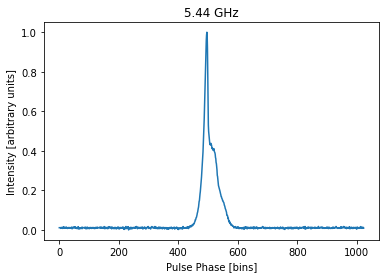

In [43]:
#Choose which profile to plot
k = 0
#Plot the normalized data
plt.plot(mata_norm[k])
plt.title('5.44 GHz')
plt.xlabel('Pulse Phase [bins]')
plt.ylabel('Intensity [arbitrary units]')
plt.show()

### Run the code

Iteration #1
chi squared: 5.729
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.97
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.353
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.131
The residuals are less than 5% or less than the off-pulse RMS


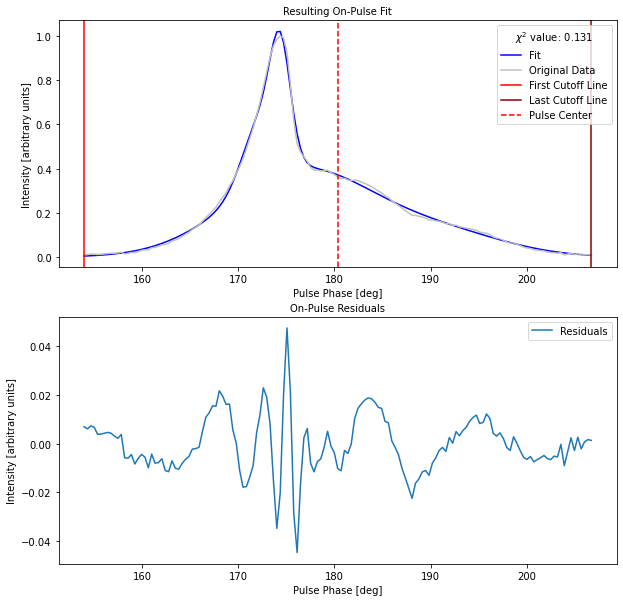

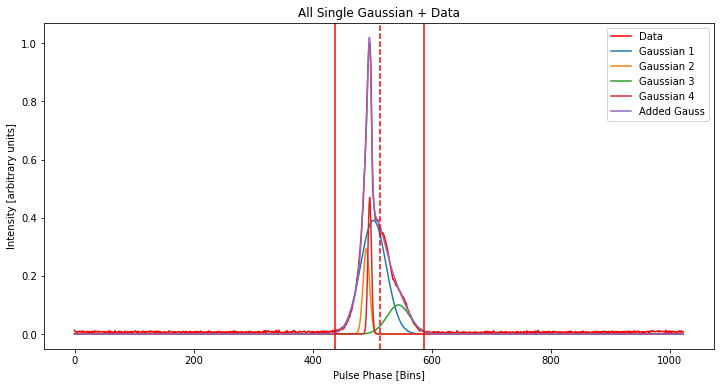

fwhm, fwhm_deg, uncert, uncer_deg:
15 5.2734375 0.0279125257441169 0.009812997331916097


In [44]:
#def iterate_fit(data, k, smooth = False):
    k = 2
    data = mata_norm
    smooth = False
    resids = []
    resids_percent = False
    iteration = 1
    param_arr = []
    resids_params = []
    mean_baseline = False
    show_all = True
    #Iterate through fitting code while adding a gaussian every time until residuals are less than 5%
    while resids_percent == False:
                   
        print('Iteration #' + str(iteration))
        resids, param_arr, fit_arr, on_pulse, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
        force_smooth, chi_squared = gauss_fit(data, k, iteration, param_arr, resids_params, mean_baseline, smooth)
        
        if (force_smooth == True) and (smooth == True) and (iteration == 11):
            print('Unable to create a fit with 10 Gaussians and smoothed profiles.')
            if mean_baseline == False:
                print('Will now average all off-pulse values to their mean value.')
                mean_baseline = True
                iteration = 1
            elif mean_baseline == True:
                print('Tried all options, no fit is possible')
                resids_percent = True
        #If the residuals are smaller than 5% we stop, if they are larger we iterate again
        elif (max(np.abs(resids)) < off_pulse_rms) or ((max(resids)< 0.05) and (min(resids) > -0.05)):
            resids_percent = True
            print("The residuals are less than 5% or less than the off-pulse RMS")
            plotting(iteration, data[k], x, param_arr, on_pulse, resids, first_cutoff, last_cutoff, pulse_center, chi_squared, \
                     show_all)
        else:
            resids_percent = False
            print("The residuals are more than 5% or more than the off-pulse RMS")
            iteration = iteration + 1
            if force_smooth == True:
                iteration = 1
                smooth = True

    gaussian_added = fit_arr
    fwhm = calculate_fwhm(gaussian_added)
    fwhm_deg = val_to_deg(fwhm, data, k)
    #plt.plot(x, gaussian_added)
    
    uncertainties = width_uncert(data[k], x, first_cutoff, last_cutoff, param_arr, k)
    uncert_deg = val_to_deg(uncertainties, data, k)
    print('fwhm, fwhm_deg, uncert, uncer_deg:')
    print(fwhm, fwhm_deg, uncertainties, uncert_deg)
#uncert_width = width_uncert(data[k], first_cutoff, last_cutoff)

In [46]:
uncertainties = width_uncert(data[k], x, first_cutoff, last_cutoff, param_arr, k)
print(uncertainties)

0.0279125257441169
